In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from tqdm import tqdm
from torch import optim

In [15]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_size = int(0.9 * len(trainset))
valid_size = int(0.1 * len(trainset))
_,validset = torch.utils.data.random_split(trainset, [train_size, valid_size])


train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(
    validset, batch_size = 100, shuffle = False, num_workers = 2
)


testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
print(train_loader.dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], scale=(0.8, 1.2), shear=[-10.0, 10.0])
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [17]:
for (X_train, Y_train) in train_loader:
    print(f"X_train: {X_train.size()} type: {X_train.type()}")
    print(f"Y_train: {Y_train.size()} type: {Y_train.type()}")
    break

X_train: torch.Size([128, 3, 32, 32]) type: torch.FloatTensor
Y_train: torch.Size([128]) type: torch.LongTensor


In [18]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [19]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [20]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [21]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [22]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using PyTorch version: {torch.__version__}, Device: {DEVICE}")

model = ResNet50().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


Using PyTorch version: 1.13.1+cu116, Device: cuda


In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [24]:
def train(model, train_loader, optimizer, bar):
    model.train()
    total_loss = 0
    total_cnt = 0
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_cnt += image.shape[0]
    return total_loss / total_cnt

In [25]:
def evaluate(model, test_loader, train_loader):
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            prediction = output.max(1, keepdim=True)[1]
            test_correct += prediction.eq(label.view_as(prediction)).sum().item()
    train_correct = 0
    with torch.no_grad():
        for image, label in train_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            prediction = output.max(1, keepdim=True)[1]
            train_correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_accuracy = 100. * test_correct / len(test_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    return test_accuracy, train_accuracy

In [26]:
EPOCHS = 100
train_loss_save = []
test_loss_save = []
train_acc_save = []
test_acc_save = []
bl = True
bar = tqdm(range(1, EPOCHS + 1), total=EPOCHS, desc='Train ')
for Epoch in bar:
    train_loss = train(model, train_loader, optimizer, bar)
    test_accuracy, train_accuracy = evaluate(model, test_loader, valid_loader)
    scheduler.step()
    bar.set_postfix(
            test_accuracy=f"{test_accuracy:0.3f}",
            train_loss=f"{train_loss:0.3f}",
            train_accuracy=f"{train_accuracy:0.3f}",
        )
    if (bl & (test_accuracy > 82)):
        print("Beat Alexnet : "+str(Epoch))
        bl = False
    train_acc_save.append(train_accuracy)
    train_loss_save.append(train_loss)
    test_acc_save.append(test_accuracy)

Train :  25%|██▌       | 25/100 [47:46<2:22:53, 114.31s/it, test_accuracy=82.190, train_accuracy=78.300, train_loss=0.005]

Beat Alexnet : 25


Train : 100%|██████████| 100/100 [3:10:02<00:00, 114.02s/it, test_accuracy=92.120, train_accuracy=97.020, train_loss=0.001] 


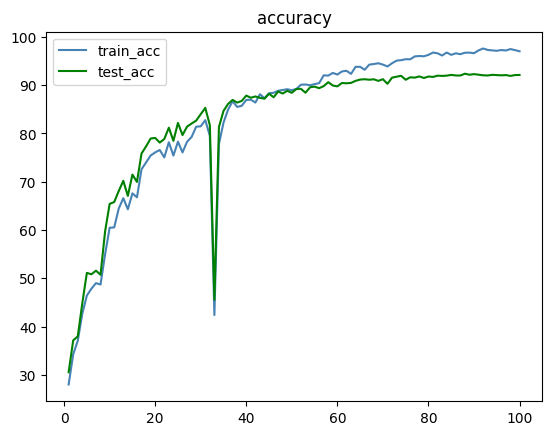

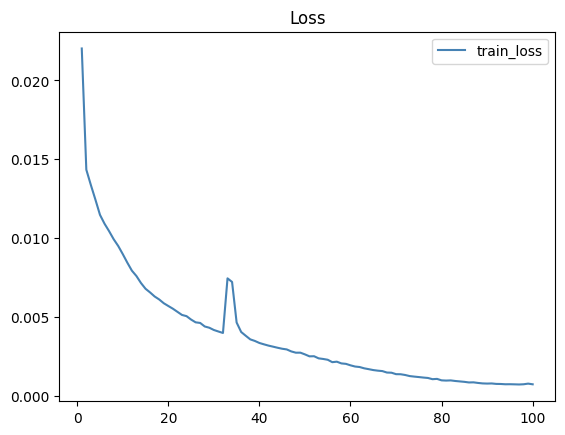

In [27]:
from matplotlib import pyplot as plt
x = [i for i in range (1, EPOCHS+ 1)]


plt.plot(x, train_acc_save, color='steelblue', label = 'train_acc')
plt.plot(x, test_acc_save, color='green', label = 'test_acc')
plt.title('accuracy')
plt.legend()
plt.savefig('./result/result_ResNet50_new_accuracy.png')
plt.show()
# Second Subplot
plt.plot(x, train_loss_save, color='steelblue', label = 'train_loss')
plt.legend()
plt.title('Loss')
plt.savefig('./result/result_ResNet50_new_loss.png')

In [28]:
PATH = './ResNet18.pt'
torch.save(model.state_dict(), PATH)

In [29]:
print("train_set : " + str(train_acc_save[-1]))
print("test_set : " + str(test_acc_save[-1]))


train_set : 97.02
test_set : 92.12
